# Overview

This colab demonstrates the steps to use the DeepLab model to perform semantic segmentation on a sample input image. Expected outputs are semantic labels overlayed on the sample image.

### About DeepLab
The models used in this colab perform semantic segmentation. Semantic segmentation models focus on assigning semantic labels, such as sky, person, or car, to multiple objects and stuff in a single image.

# Instructions
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Use a free TPU device</h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

## Import Libraries

In [1]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

# %tensorflow_version 1.x
import tensorflow as tf

## Import helper methods
These methods help us perform the following tasks:
* Load the latest version of the pretrained DeepLab model
* Load the colormap from the PASCAL VOC dataset
* Adds colors to various labels, such as "pink" for people, "green" for bicycle and more
* Visualize an image, and add an overlay of colors on various regions

In [2]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.compat.v1.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    # return resized_image, seg_map


    return resized_image, seg_map

In [3]:
def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

In [4]:
!curl https://raw.githubusercontent.com/CSAILVision/sceneparsing/master/objectInfo150.csv --output 'objectInfo150.csv'
import pandas as pd

ade20k_labels_info = pd.read_csv('objectInfo150.csv')
labels_list = list(ade20k_labels_info['Name'])
ade20k_labels_info.head()
labels_list.insert(0, 'others')
len(labels_list)


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ])

  return colormap



LABEL_NAMES = np.asarray(labels_list)

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  5803  100  5803    0     0   5891      0 --:--:-- --:--:-- --:--:--  5897
100  5803  100  5803    0     0   5889      0 --:--:-- --:--:-- --:--:--  5897


In [5]:
def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()

## Select a pretrained model
We have trained the DeepLab model using various backbone networks. Select one from the MODEL_NAME list.

In [6]:
MODEL_NAME = "latest_model" #@param ["mobilenetv2_coco_voctrainaug", "mobilenetv2_coco_voctrainval", "xception_coco_voctrainaug", "xception_coco_voctrainval", "latest_model"]

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'latest_model':
        'deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz',
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

# model_dir = tempfile.mkdtemp()
path = os.getcwd()
tf.io.gfile.makedirs(path)

download_path = os.path.join(path, _TARBALL_NAME)
print('downloading model, this might take a while...')
# urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
#                    download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


## Run on sample images

Select one of sample images (leave `IMAGE_URL` empty) or feed any internet image
url for inference.

Note that this colab uses single scale inference for fast computation,
so the results may slightly differ from the visualizations in the
[README](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md) file,
which uses multi-scale and left-right flipped inputs.

running deeplab on image https://images.unsplash.com/photo-1559455237-b7806697aac5?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MTh8fG1pZGRsZSUyMGNsYXNzfGVufDB8fDB8fA%3D%3D&w=1000&q=80...


C:\Users\darklane\AppData\Local\Temp\ipykernel_11348\1861173341.py:45: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(513, 384)


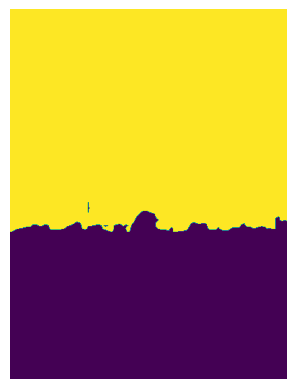

In [10]:

SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
# IMAGE_URL = 'https://lh3.googleusercontent.com/fife/AAWUweUf7yurKDa59qaKsw-uA6lX8o1TwJ1ZUunP5MYY72kFdhzJwr1m7VTkRQztspf5sndqJsC4x6R1CnOsMFGbZjHgOZqSS51BzGi7f8QBbFoo6ZZiHPisVaN2pQi4BtV_eO3tHf9LH34ZpKOOEEJvDmA3Jqn1QrWpa6BotOUfftBpIv0cqjz1DYQjFoCS5N5IFwa0PmufmZb29Tmo6FY1-9yvGmYT5R1NPMwqs3wihMw8vXWkhsPZz95hCGZ_ogZUh9JunI127oMC1qYJaYVaRzRWiEMksGsx8wS0K10X_d0qI8bg9MnQwM8CnGPG4Lqz4K4nrpThRB_4XhUV-5NyzPhKU_vGpvdwPwIFVi3K_EDhNTHH1x_d17tWXtSCGIwJMsvP9rpmcUjU4E2LSswJx2l9p3L23srpPMjAnYEutrQdJ9uAFXldxJy9X_8-m78wsPsDnxIHBH6WaoIErj9jw1hMlSVJf2gWkPU_gs1ARRp_q5FcWdWRuMeqrtziS-dZd4LVAiNPRmGhV8bhOl_pyYXqLrXfNdv-aTJBDbntHzhgYuOcf7odXF8wy3w4ObCUJKnCdOdzc2ej79-YBmsBLdNw2CXaNleQolCYRM2M1YaE5jovd-rPorWpfPFaZEM8i4jBpUVcOwiNkZNQ5WQP6u3Rwbin2vxuy8MOxVd3XlBvLb7p7QHT6FCWzVrRAe7bZsmClPKRiGvQ5V-4zfhgY2DyhzzBrfPOcc6hV6XNFwreIgT9-Esed7jH5ESEqyXLmK4zNDRPfoGgNeEgsXRqhOH9bFt2B5bmZO103d7xmiOX3ehXjPNrq36aHLUeL8n_owslKuKzhg_lFQEHDZNg_N8nR-zGt2p9VbHzFC3sRGWSqvd6m2xTD68gZTkBrhUS2q4JHGtmcnozoc2vCtfmPyF7-8Wq6tJCxFfeyjpmc1-f4xQrY7p_y3uOXdHGSNXY5ST4J8QT-yH8p32zMi_qkvh30-reRz8xPpYELPu0lebRDyvTiza6Wm3qhI6ObCBl1AlNqatfbR6lVxxhY7FIThZYiPYm68pqo7QLdR5bHJqS4VSXpZQFBEyqGz0UMAtt5fEV7oQ5cb4dvq1XlR5Dw7zYyS-c_9nslvr0AgGrmtKxpN7r7z5T8CpkKy9OG1wGQsxtQ1cMhBxkZtcOZagL3QCmn8_G7gK3rJ734hy7PcuHll5LCshAoSHT0BrQ5iklLQsoJ3lJivioNYv5J2B5s8_BHGqnAVYSJUt_8eHFtZksKxiPCdplGXOmtaUQascpqgnTw-0=w2880-h1464'  #@param {type:"string"}
IMAGE_URL = 'https://images.unsplash.com/photo-1559455237-b7806697aac5?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MTh8fG1pZGRsZSUyMGNsYXNzfGVufDB8fDB8fA%3D%3D&w=1000&q=80'

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)


  sky_class = 3  # sky class in the model
  sky_mask = np.zeros(seg_map.shape,dtype=np.int64)

  # filter sky
  sky_mask = np.where(seg_map == sky_class, 1, 0)

  print(sky_mask)
  print(sky_mask.shape)

  # display the sky mask
  plt.imshow(sky_mask, ) 
  plt.axis('off')
  plt.savefig('sky_mask.jpg')
  # remov the axis
  plt.axis('off')


  # vis_segmentation(resized_im, seg_map)
  # vis_segmentation(resized_im, sky_mask)



image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

## What's next

* Learn about [Cloud TPUs](https://cloud.google.com/tpu/docs) that Google designed and optimized specifically to speed up and scale up ML workloads for training and inference and to enable ML engineers and researchers to iterate more quickly.
* Explore the range of [Cloud TPU tutorials and Colabs](https://cloud.google.com/tpu/docs/tutorials) to find other examples that can be used when implementing your ML project.
* For more information on running the DeepLab model on Cloud TPUs, see the [DeepLab tutorial](https://cloud.google.com/tpu/docs/tutorials/deeplab).
